In [4]:
#! -*- coding: utf-8 -*-

# バイナリブラックホール信号入門

このチュートリアルでは、次のチュートリアルのワークスペースといくつかの確認質問を提供しています。

https://losc.ligo.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html

### モジュールのインポートと設定

In [5]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
import sys

pyversion = sys.version_info.major
if pyversion == 2: 
    import urllib2
else:
    import urllib.request
    
import os

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

### データダウンロードのための便利な関数を定義する

In [6]:
# -- Handy function to download data file, and return the filename
def download(url):
    filename = url.split('/')[-1]
    if os.path.exists(filename):
        print('File ' + filename + " exists. Returning" )
        return filename

    print('Downloading ' + url )
    if pyversion == 2: 
        r = urllib2.urlopen(url).read()
        f = open(filename, 'w')   # write it to the right filename
        f.write(r)
        f.close()
    else:
        urllib.request.urlretrieve(url, filename)  
    print("File download complete")
    return filename

## ファイルのダウンロード

In [7]:
download('https://losc.ligo.org/s/sample_code/readligo.py')
download('https://losc.ligo.org/s/events/BBH_events_v3.json')
download('https://losc.ligo.org/s/sample_code/readligo.py')
fn_H1 = download('https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V2-1126259446-32.hdf5')
fn_L1 = download('https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_4_V2-1126259446-32.hdf5')
fn_template = download('https://losc.ligo.org/s/events/GW150914/GW150914_4_template.hdf5')

File readligo.py exists. Returning
File download complete
File readligo.py exists. Returning
File H-H1_LOSC_4_V2-1126259446-32.hdf5 exists. Returning
File download complete
File download complete


## PSDをプロットする

1. ハンフォードとリビングストンのデータのPSDのプロットを作成します。
 * https://losc.ligo.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html の例
1. プロットでは、どのようなノイズの特徴がありますか？
1. このデータの最も感度の高い周波数帯は何ですか？


Text(0.5,0,'Freq (Hz)')

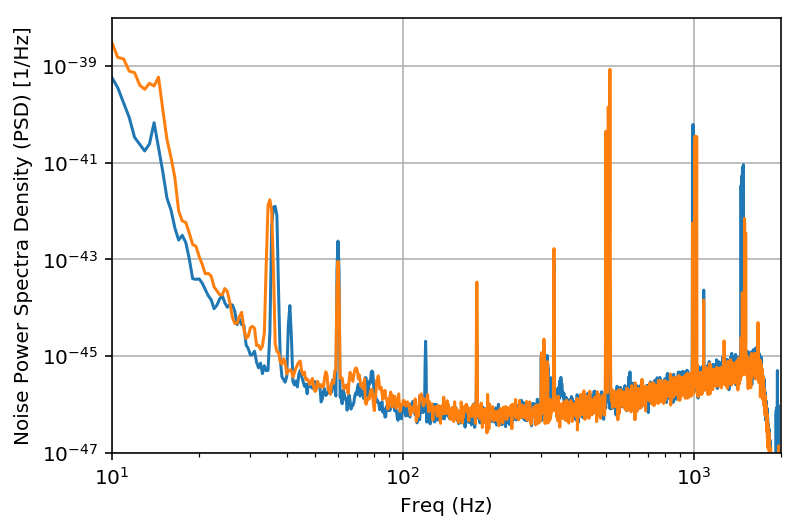

In [12]:
import readligo as rl
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

#-- Plot a PSD with 128 seconds of data 
ts = time_L1[1] - time_L1[0]      #-- Time between samples
fs = int(1.0 / ts)          #-- Sampling frequency
length = 128                #-- Number of seconds
#-- Plot a PSD with 128 seconds of data 
ts = time_H1[1] - time_H1[0]      #-- Time between samples
fs = int(1.0 / ts)          #-- Sampling frequency
length = 128                #-- Number of seconds

strain_seg_H1 = strain_H1[0:(length*fs)]
time_seg_L1 = time_H1[0:(length*fs)]
strain_seg_L1 = strain_L1[0:(length*fs)]
time_seg_L1 = time_L1[0:(length*fs)]

Pxx_H1, freqs_H1 = mlab.psd(strain_seg_H1, Fs=fs, NFFT=2*fs)
plt.loglog(freqs_H1, Pxx_H1)
plt.axis([10, 2000, 1e-47, 1e-38])
plt.grid('on')
plt.ylabel('Noise Power Spectra Density (PSD) [1/Hz]')
plt.xlabel('Freq (Hz)')

Pxx_L1, freqs_L1 = mlab.psd(strain_seg_L1, Fs=fs, NFFT=2*fs)
plt.loglog(freqs_L1, Pxx_L1)
plt.axis([10, 2000, 1e-47, 1e-38])
plt.grid('on')
plt.ylabel('Noise Power Spectra Density (PSD) [1/Hz]')
plt.xlabel('Freq (Hz)')

## GW150914のSNRを計算する

GW150914のマッチトフィルタSNRを計算します。これはここでどのように行われているのかを見ることができます：

https://losc.ligo.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html

## 白色化したデータをプロットする

1. GW150914のデータをホワイトニングし、バンドパスします。
1. ホワイトニングとバンドパスの後、データをプロットします。
1. 信号が見えますか？
1. マッチトフィルタリングは、白色化されたデータで実行される。何でこれが大切ですか？


File H-H1_LOSC_4_V2-1126259446-32.hdf5 exists. Returning


Text(0.5,1,'WHITENED strain')

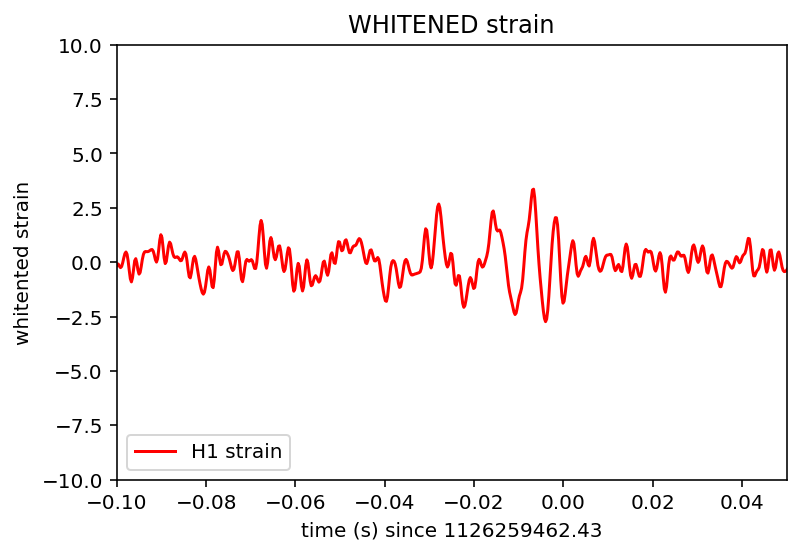

In [13]:
#-- Download a data file containing GW150914 
url = 'https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V2-1126259446-32.hdf5'
fn_150914 = download(url)
strain, time, chan_dict_H1 = rl.loaddata(fn_150914, 'H1')

# the time sample interval (uniformly sampled!)
t0 = 1126259462.43
dt = time[1] - time[0]
fs = int(np.round(1/dt))
rel_time = time - t0

#-- How much data to use for the ASD?
deltat = 15  # Number of seconds on each side of data
N_samp = deltat*fs

# -- Center the PSD segment on the requested time
indx = np.where(np.abs(rel_time) < dt)[0][0]
strain_seg = strain[indx-N_samp : indx+N_samp]
time_seg = rel_time[indx-N_samp : indx+N_samp]

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000

# -- Calculate PSD
Pxx, freqs = mlab.psd(strain_seg, Fs = fs, NFFT=NFFT, 
                      noverlap=NFFT/2, window=np.blackman(NFFT))

# We will use interpolations of the ASDs computed above for whitening:
# in scipy.interpolate
psd = interp1d(freqs, Pxx)

# -- Whiten
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data
strain_whiten = whiten(strain_seg,psd,dt)

# We need to suppress the high frequencies with some bandpassing:
high_freq = 600.
low_freq  = 30.
bb, ab = butter(4, [low_freq*2./fs, high_freq*2./fs], btype='band')
strain_whitenbp = filtfilt(bb, ab, strain_whiten)

#-- Plot the whitened time series
fig2 = plt.figure()
plt.plot(time_seg,strain_whitenbp,'r',label='H1 strain')

plt.xlim([-0.1,0.05])
plt.ylim([-10,10])
plt.xlabel('time (s) since '+str(t0))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('WHITENED strain')

### もっと探求する

S6データセットには、何千ものバイナリブラックホールハードウェアインジェクションが含まれています。

ドキュメントについては、以下を参照してください。
https://losc.ligo.org/s6hwcbc/

1. これらのハードウェアインジェクションのためのマッチドフィルタの実行方法に関するチュートリアルをご覧ください：https://losc.ligo.org/inj/step1/

1. S6の間、各BBHハードウェアインジェクションのSNRを計算するスクリプトを作成します。ドキュメントはここにあります： https://losc.ligo.org/s6hwcbc/

[u'NO_BURST_HW_INJ', u'NO_CBC_HW_INJ', u'CBC_CAT1', u'BURST_CAT2', u'BURST_CAT1', u'CBC_CAT2', 'DEFAULT', u'CBC_CAT3', u'NO_CW_HW_INJ', u'NO_STOCH_HW_INJ', u'NO_DETCHAR_HW_INJ', u'BURST_CAT3', u'DATA']


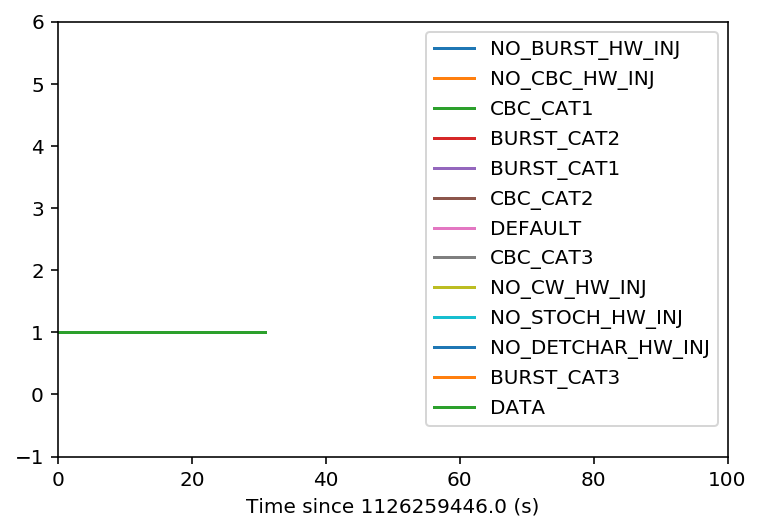

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import readligo as rl

strain, time, dq = rl.loaddata('H-H1_LOSC_4_V2-1126259446-32.hdf5')
dt = time[1] - time[0]
fs = 1.0 / dt
print dq.keys()

plt.plot(dq['NO_BURST_HW_INJ'], label='NO_BURST_HW_INJ')
plt.plot(dq['NO_CBC_HW_INJ'], label='NO_CBC_HW_INJ')
plt.plot(dq['CBC_CAT1'], label='CBC_CAT1')
plt.plot(dq['BURST_CAT2'], label='BURST_CAT2')
plt.plot(dq['BURST_CAT1'], label='BURST_CAT1')
plt.plot(dq['CBC_CAT2'], label='CBC_CAT2')
plt.plot(dq['DEFAULT'], label='DEFAULT')
plt.plot(dq['CBC_CAT3'], label='CBC_CAT3')
plt.plot(dq['NO_CW_HW_INJ'], label='NO_CW_HW_INJ')
plt.plot(dq['NO_STOCH_HW_INJ'], label='NO_STOCH_HW_INJ')
plt.plot(dq['NO_DETCHAR_HW_INJ'], label='NO_DETCHAR_HW_INJ')
plt.plot(dq['BURST_CAT3'], label='BURST_CAT3')
plt.plot(dq['DATA'], label='DATA')
plt.xlabel('Time since ' + str(time[0]) + ' (s)')
plt.axis([0, 100, -1, 6])
plt.legend()
plt.show()
